# AI4Food - A Challenge for Crop Type Classification at Field Level




## Get started with the challenge

This notebook will get you started with downloading, exploring and analysing the input and output data of the challenge.

The proposed challenge will focus on crop type classification based on a time-series input of _Sentinel-1_, _Sentinel-2_ and _Planet Fusion_ data. The challenge will cover two areas of interest, in Germany and South Africa, with high-quality cadastral data on field boundaries and crop types as ground truth input. 

The challenge will consist of two tracks:
  * Within-season crop identification, over the South Africa AOI
  * Reusability of models for crop identification from one growing season to the next, over the Germany AOI

The participants will not be required to participate in both challenges. However, the evaluation mechanism behind both tracks are the same, as well as the rules and prize catalogue.

This notebook showcases how to download and process the data, but you are free to use any open souce Python library specifically designed to deal with Earth Observation data such as [eo-learn](https://eo-learn.readthedocs.io/en/latest/index.html). In this notebook, the data is stored as `tif` images, `numpy` arrays and `geopandas` dataframes to facilitate processing operations and `torch` is preferred for data processing and training. However, you can use any other Python tool of preference to process the provided data.

The notebook also showcases how to generate a valid submission file.

As per challenge rules, the following applies:
 * no data source other than the ones provided can be used to produce your outputs;
 * pre-trained models are allowed;
 * the test data cannot be used for training of the models; 
 * the target _cultivated land_ map cannot be used as an input to the method (i.e. trivial solution).

Code for the winning solutions will be reviewed to ensure rules have been followed.

The content of the notebook is as follows:

0. [Requirements](#requirements)


1. [Data overview](#data-overview)

   1.1. [Area of Interest for Brandenburg](#aoi1)
   
   1.2. [Data Types for Brandenburg](#dt1)
   
   1.3. [Area of Interest for South Africa](#aoi2)

   1.4. [Data Types for South Africa](#dt2)
   
   
2. [Data processing and ML Training](#data-processing)
    
   2.1. [Exploiting _Planet Fusion_ Data](#epfd)
   
   2.2. [Exploiting _Sentinel-2_ Data](#es2d)


3. [Prepare a Submission](#submission-example)

   3.1 [Submission Example](#prepare-a-submission)

In [ ]:
# ensure you have the required python packages
import sys
!{sys.executable} -m pip install -r requirements.txt


In [1]:
# Jupyter notebook related
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Built-in modules
import os
import glob
import json
from typing import Tuple, List
from datetime import datetime, timedelta
import pickle
import shutil
import warnings
warnings.filterwarnings('ignore')

# Basics of Python data handling and visualization
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from tqdm.auto import tqdm

# Data reding for training validation purposes:
from utils.data_transform import PlanetTransform, Sentinel1Transform, Sentinel2Transform
from utils.planet_reader import PlanetReader
from utils.sentinel_1_reader import S1Reader
from utils.sentinel_2_reader import S2Reader
from utils.data_loader import DataLoader
from utils.baseline_models import SpatiotemporalModel
from utils import train_valid_eval_utils as tveu
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.nn import NLLLoss
import torch
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix


## 0. Requirements  <a name="requirements"></a>

In order to download the data through the provided APIs you would need to set-up an account for [Radiant Earth Foundation](https://www.radiant.earth/). Check the following options.

#### If you are using the Radiant Earth Foundation resources

TODO: WAITING INPUTS FROM RADIANT EARTH (e.g. scripts and credentials to download data into `notebook/data` directory of this notebook.) 

#### If you are using your own resources

TODO: WAITING INPUTS FROM RADIANT EARTH (e.g. scripts and credentials to download data into `notebook/data` directory of this notebook.)
 
#### If you cannot use the APIs

Check the challenge description for alternative options to retrieve the data as a single zipped file.

## 1. Data Overview <a name="data-overview"></a>

This section gives an overview of all the necessary data to train your model and how to download them. 

In general, the data sources to download are the following:

 * the reference polygons including target fields and crop types to define the area-of-interest (AOI);
 * the [Sentinel-1](https://docs.sentinel-hub.com/api/latest/data/sentinel-1-grd/) and [Sentinel-2](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/) time-series;
 * the [Planet Fusion]( https://assets.planet.com/docs/Planet_fusion_specification_March_2021.pdf) daily time-series;
 * the [Planet Fusion]( https://assets.planet.com/docs/Planet_fusion_specification_March_2021.pdf) median filtered time-series for every 5 days (for teams with **limited computational resources**, it is highly recommended);
 

**NOTE**: It is not mandatory to exploit all of the data sources. The challenge participants are free to choose a subset or a combination of data sources to exploit for model training purposes.  
 
The AOIs chosen for this challenge are in the [Brandenburg State of Germany](https://en.wikipedia.org/wiki/Brandenburg) and the [Republic of South Africa](https://en.wikipedia.org/wiki/South_Africa) as detailed below. 

**Brandenburg-Germany Data** 

The Brandenburg-Germany data contains following time series in UTM zone 33N (i.e. `epsg:32633`) from _Sentinel-1_, _Sentinel-2_ and _Planet Fusion_:
 * **For Training:** 
    * _Planet Fusion_ Surface Reflection (PF-SR) data of 2018 from tile 18E-242N consisting of 365 daily observations, approximately 122 GB,
    * _Planet Fusion_ Surface Reflection (PF-SR) data of 2018 from tile 18E-242N, median filtered with a size of five days and the same stride. For example, the a median computed image for 2018-01-03 contains the band-wise median computed over the period 2018.01.01 - 2018.01.05, approximately 25 GB,
    * _Sentinel-1_ ascending and descending orbit observations of entire 2018 from tile 18E-242N, approximately 9 GB,
    * _Sentinel-2_ observations of entire 2018 from tile 18E-242N, approximately 12 GB,
    * _Ground-truth:_ _br-18E-242N-crop-labels-train-2018.geojson:_ crop field polygons with `crop_ids` and `crop_names` based on cadastral data.
 * **For Testing:** 
    * _Planet Fusion_ Surface Reflection (PF-SR) data of 2019 from tile 17E-243N consisting of 365 daily observations, approximately 122 GB,
    * _Planet Fusion_ Surface Reflection (PF-SR) data of 2019 from tile 17E-243N, median filtered with a size of five days and the same stride. For example, the first image for Brandenburg tile 33N/17E-243N is 2019-01-03, which is contains the band-wise median computed over the period 2019.01.01 - 2019.01.05, approximately 25 GB,
    * _Sentinel-1_ ascending and descending orbit observations of entire 2019 from tile 17E-243N, approximately 9 GB,
    * _Sentinel-2_ observations of entire 2019 from tile 17E-243N, approximately 12 GB,
    * _Ground-truth_: _br-17E-243N-crop-labels-test-2019.geojson_ crop field polygons without `crop_ids` and `crop_names` which are reserved for the evaluation of challenge submissions. 

**South Africa Data** 

The South-Africa data contains following time series in UTM zone 34S (i.e. `epsg:32734`) from _Sentinel-1_, _Sentinel-2_ and _Planet Fusion_:
 * **For Training:** 
    * _Planet Fusion_ Surface Reflection (PF-SR) data from tiles 19E-258N and 19E-259N consisting of 244 daily observations between April 2017 - December 2017, approximately 155 GB,
    * _Planet Fusion_ Surface Reflection (PF-SR) data of 2017 from tiles 19E-258N and 19E-259N, median filtered with a size of five days and the same stride. For example, the a median computed image for 2017-01-03 contains the band-wise median computed over the period 2017.01.01 - 2017.01.05, approximately 30 GB,
    * _Sentinel-1_ ascending orbit observations of 2017 from tiles 19E-258N and 19E-259N, approximately 3.6 GB,
    * _Sentinel-2_ observations of 2017 from tiles 19E-258N and 19E-259N, approximately 13 GB,
    * _Ground-truth:_ _sa-19E-258N-crop-labels-train-2017.geojson_ and _sa-19E-259N-crop-labels-train-2017.geojson_,  crop field polygons with `crop_ids` and `crop_names` based on cadastral data.
     
 * **For Testing:** 
    * _Planet Fusion_ Surface Reflection (PF-SR) data from tile 20E-259N consisting of 244 daily observations between April 2017 - December 2017, approximately 77 GB,
    * _Planet Fusion_ Surface Reflection (PF-SR) data of 2017 from tile 20E-259N, median filtered with a size of five days and the same stride. For example, the a median computed image for 2017.01.03 contains the band-wise median computed over the period 2017.01.01 - 2017.01.05, approximately 15 GB,
    * _Sentinel-1_ ascending orbit observations of 2017 from tile 20E-259N, approximately 1.8 GB,
    * _Sentinel-2_ observations of 2017 from tile 20E-259N, approximately 4.6 GB,
    * _Ground-truth_: _sa-20E-259N-crop-labels-test-2017.geojson_ crop field polygons without `crop_ids` and `crop_names` which are reserved for the evaluation of challenge submissions. 
 



### 1.1 Area of Interest for Brandenburg <a name="aoi1"></a>

In order to check the AOI for Brandenburg, you can start with the ground-truth files: 
* _br-18E-242N-crop-labels-train-2018.geojson_ -> For Training and Validation
* _br-17E-243N-crop-labels-test-2019.geojson_  -> For Test

After your download, it is supposed to be placed in `data` folder of this notebook:

In [43]:
brandenburg_tr_labels_dir='data/brandenburg-gt/br-18E-242N-crop-labels-train-2018.geojson'
brandenburg_te_labels_dir='data/brandenburg-gt/br-17E-243N-crop-labels-test-2019.geojson'

In order to explore data types in the ground truth of 2018 (`for training`), you can run the following cell. It will summarize the `geojson` data belonging to the AOI, which have 2534 entries, and 5 columns representing field ID, area of the field in square meters, length of the field in meters, crop ID, crop name and the geomtry of the field as polygon:  

In [44]:
#CHECK TARGET DATA FORMAT IN TRAINING GROUND-TRUTH POLYGONS:

brandenburg_tr_labels=gpd.read_file(brandenburg_tr_labels_dir)
print('INFO: Number of fields: {}\n'.format(len(brandenburg_tr_labels)))
brandenburg_tr_labels.info()
brandenburg_tr_labels.tail()


INFO: Number of fields: 2534

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2534 entries, 0 to 2533
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   fid         2534 non-null   int64   
 1   SHAPE_AREA  2534 non-null   float64 
 2   SHAPE_LEN   2534 non-null   float64 
 3   crop_id     2534 non-null   int64   
 4   crop_name   2534 non-null   object  
 5   geometry    2534 non-null   geometry
dtypes: float64(2), geometry(1), int64(2), object(1)
memory usage: 118.9+ KB


fid    SHAPE_AREA    SHAPE_LEN  crop_id     crop_name  \
2529  210145  259644.80075  2922.908013        5          Corn   
2530  210149   11260.80940   433.843678        2           Rye   
2531  210174  593211.62605  3766.251880        5          Corn   
2532  210179   48034.13890  1210.785843        9  Forage Crops   
2533  210180  428209.99690  3885.101917        6     Oil Seeds   

                                               geometry  
2529  MULTIPOLYGON (((451162.920 5809950.180, 451386...  
2530  MULTIPOLYGON (((452645.460 5809120.610, 452645...  
2531  MULTIPOLYGON (((451948.160 5827166.390, 451948...  
2532  MULTIPOLYGON (((439830.770 5808003.000, 439881...  
2533  MULTIPOLYGON (((437976.290 5828007.960, 437952...

In order to explore data types in the ground truth of 2019 (`for the evaluation of challenge`), you can run the following cell. It will summarize the `geojson` data belonging to the AOI, which have 2064 entries, and 5 columns representing field ID, area of the field in square meters, length of the field in meters, crop ID, crop name and the geomtry of the field as polygon, as same with the example above. However the column `crop_id` has always value _0_, and `crop_name` is only _No Data_, because they are reserved for the evaluation of the challenge. Participants of the challenge can only benefit from the `geometry` column to make predictions for each field bounded by a polygon:  

In [45]:
#CHECK TARGET DATA FORMAT IN EVALUATION GROUND-TRUTH POLYGONS:

brandenburg_te_labels=gpd.read_file(brandenburg_te_labels_dir)
print('INFO: Number of fields: {}\n'.format(len(brandenburg_te_labels)))
brandenburg_te_labels.info()
brandenburg_te_labels.tail()


INFO: Number of fields: 2064

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2064 entries, 0 to 2063
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   fid         2064 non-null   int64   
 1   SHAPE_AREA  2064 non-null   float64 
 2   SHAPE_LEN   2064 non-null   float64 
 3   crop_id     2064 non-null   int64   
 4   crop_name   2064 non-null   object  
 5   geometry    2064 non-null   geometry
dtypes: float64(2), geometry(1), int64(2), object(1)
memory usage: 96.9+ KB


fid    SHAPE_AREA    SHAPE_LEN  crop_id crop_name  \
2059  211781  53043.495269  1293.383835        0   No Data   
2060  211917  39686.602456   921.331461        0   No Data   
2061  211995   4248.183887   356.275619        0   No Data   
2062  211997  32367.320191   768.085690        0   No Data   
2063  212315   4593.800455   287.130172        0   No Data   

                                               geometry  
2059  MULTIPOLYGON (((422780.790 5847737.560, 422759...  
2060  MULTIPOLYGON (((423316.480 5847950.820, 423323...  
2061  MULTIPOLYGON (((428263.130 5853521.381, 428213...  
2062  MULTIPOLYGON (((428123.080 5853365.400, 428119...  
2063  MULTIPOLYGON (((429146.640 5847412.550, 429147...

When you look at the crop labels and crop names in training ground-truths you are supposed to see 9 crop types with the following IDs:
 * 1: Wheat
 * 2: Rye
 * 3: Barley
 * 4: Oats
 * 5: Corn
 * 6: Oil Seeds
 * 7: Root Crops
 * 8: Meadows
 * 9: Forage Crops

In [46]:
#CHECK LABEL IDs AND LABEL NAMES: 

label_ids=brandenburg_tr_labels['crop_id'].unique()
label_names=brandenburg_tr_labels['crop_name'].unique()

print('INFO: Label IDs: {}'.format(label_ids))
print('INFO: Label Names: {}'.format(label_names))


INFO: Label IDs: [9 1 8 2 3 5 6 7 4]
INFO: Label Names: ['Forage Crops' 'Wheat' 'Meadows' 'Rye' 'Barley' 'Corn' 'Oil Seeds'
 'Root Crops' 'Oats']


These plant types are not evenly planted in the agricultural fields, so you can observe the distribution of fields with each particular crop as below: 

INFO: Number of Fields by Crop Type: 
Meadows         954
Forage Crops    339
Wheat           305
Rye             279
Corn            251
Oil Seeds       201
Barley          137
Oats             45
Root Crops       23
Name: crop_name, dtype: int64


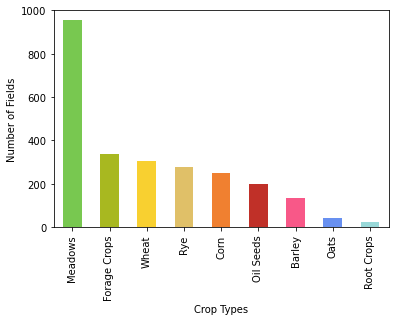

In [47]:
#CHECK FIELD DISTRIBUTION BY LABEL: 

value_counts=brandenburg_tr_labels['crop_name'].value_counts()

colors_list = ['#78C850','#A8B820','#F8D030','#E0C068', '#F08030', '#C03028', '#F85888','#6890F0','#98D8D8'] 
ax=value_counts.plot.bar(color=colors_list)
ax.set_ylabel("Number of Fields")
ax.set_xlabel("Crop Types")

print('INFO: Number of Fields by Crop Type: \n{}'.format(value_counts))


However, if we look at the per hectare distribution of each crop, we will see a different distribution, because some crops seem usually planted in larger areas:

INFO: Total Hectare per Crop Type: 
            crop_name  total_hectare
crop_id                             
1.0             Wheat    6633.129427
2.0               Rye    4601.042741
3.0            Barley    2966.949219
4.0              Oats     458.835674
5.0              Corn    5606.791864
6.0         Oil Seeds    5271.580641
7.0        Root Crops     165.655733
8.0           Meadows    2373.457948
9.0      Forage Crops    2191.064253


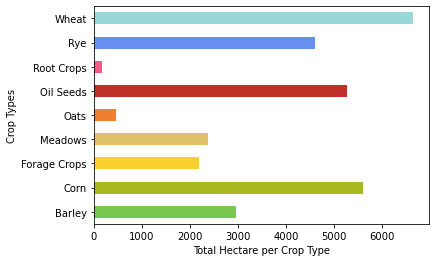

In [48]:
#CHECK TOTAL HECTARE DISTRIBUTION BY LABEL: 

hectare_distribution = pd.DataFrame(columns=["crop_name", "total_hectare"])
for name, group in brandenburg_tr_labels.groupby('crop_name'):
    total_hectare=group['SHAPE_AREA'].sum()/10000 # convert to m2 to hectare
    hectare_distribution=hectare_distribution.append({'crop_id':group.iloc[0]['crop_id'], 'crop_name':name, 'total_hectare':total_hectare}, ignore_index=True)

hectare_distribution.set_index('crop_id', inplace=True)
colors_list = ['#78C850','#A8B820','#F8D030','#E0C068', '#F08030', '#C03028', '#F85888','#6890F0','#98D8D8'] 
ax=hectare_distribution.plot.barh(color=colors_list,x='crop_name', y='total_hectare',legend=False)
ax.set_xlabel("Total Hectare per Crop Type")
ax.set_ylabel("Crop Types")

print('INFO: Total Hectare per Crop Type: \n{}'.format(hectare_distribution.sort_index()))


Moreover, if we look at how fragmented the fields for a crop type, by counting the number of fields in different hectare bins:

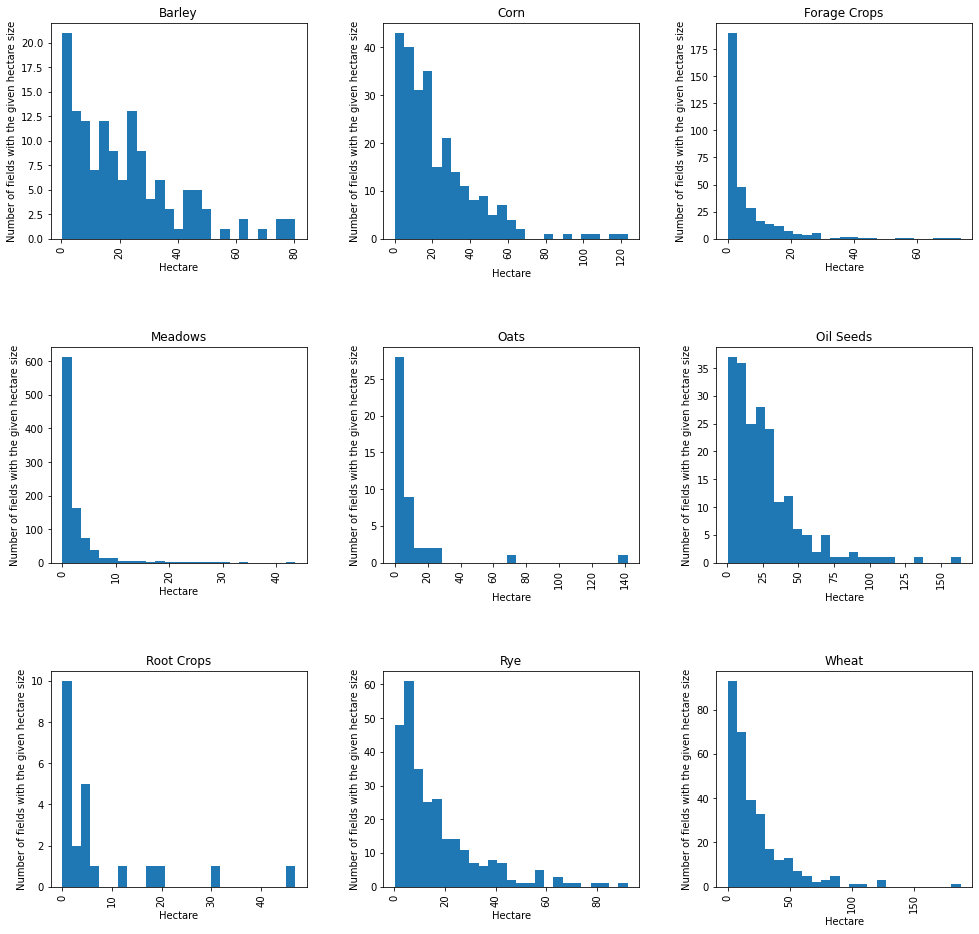

In [49]:
#CHECK HECTARE DISTRIBUTION HISTOGRAM BY LABEL: 

#Convert m2 to hectare:
histogram_data = brandenburg_tr_labels.copy(deep=True)
histogram_data['SHAPE_AREA']=brandenburg_tr_labels['SHAPE_AREA']/10000

ax=histogram_data.hist( by='crop_name',column = 'SHAPE_AREA', bins=25,figsize=(16,16))
for i in range(ax.shape[0]): 
    for j in range(ax.shape[1]): 
        ax[i][j].set_ylabel("Number of fields with the given hectare size")
        ax[i][j].set_xlabel("Hectare")
        

For Brandenburg, the ground-truths of year 2018 are from tile 18E-242N as can be observed below:

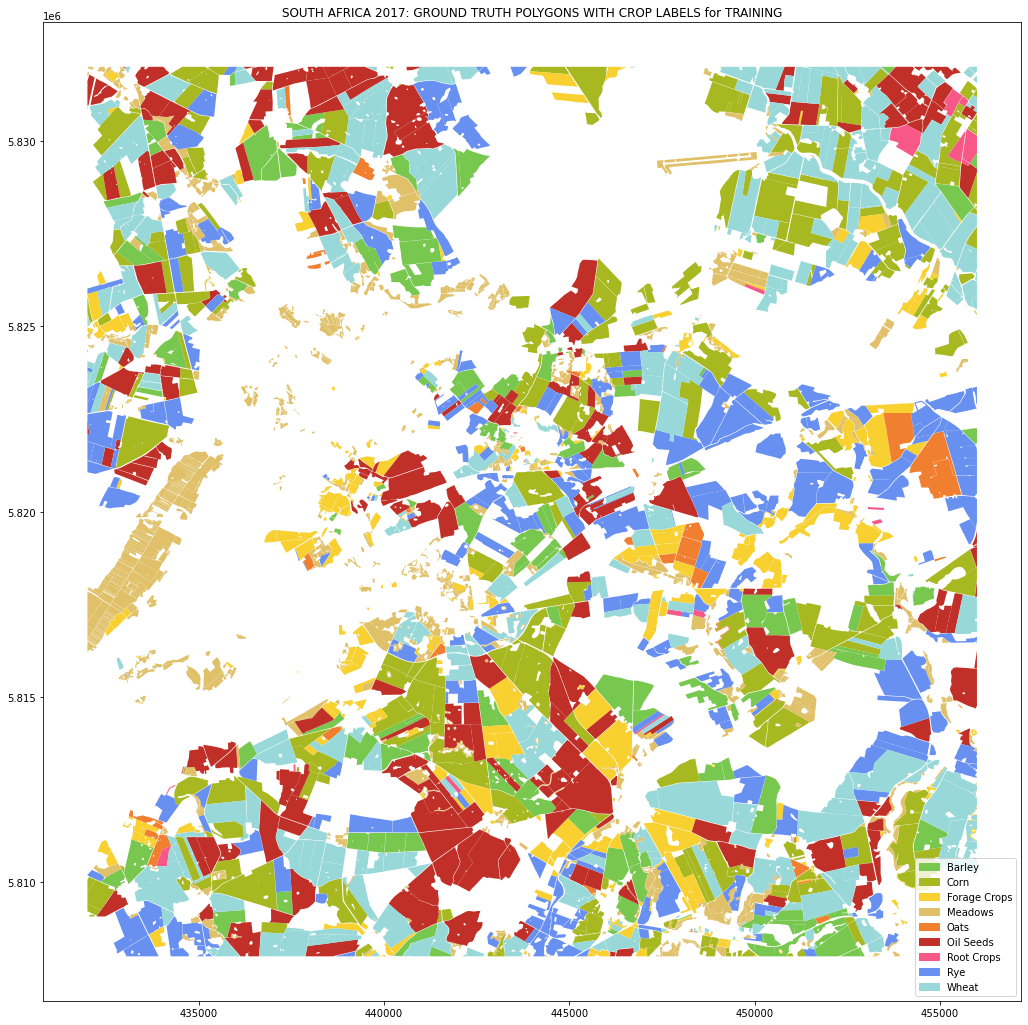

In [50]:
#DISPLAY TARGET FIELDS of 2018 FOR TRAINING ON THE MAP BY LABEL: 

fig, ax = plt.subplots(figsize=(18, 18))
counter=0
legend_elements = []
for name, group in brandenburg_tr_labels.groupby('crop_name'):
    group.plot(ax=ax,color=colors_list[counter], aspect=1)
    legend_elements.append(Patch(facecolor=colors_list[counter], edgecolor=colors_list[counter],label=name))
    counter+=1

ax.legend(handles=legend_elements,loc='lower right')
ax.title.set_text('SOUTH AFRICA 2017: GROUND TRUTH POLYGONS WITH CROP LABELS for TRAINING')


For Brandenburg, the ground-truths of year 2019 are from tile 18E-242N as can be observed below, however as you can notice, only polygons are given to you without crop names and crop IDs, because they are reserved for the evaluation of the challenge. 

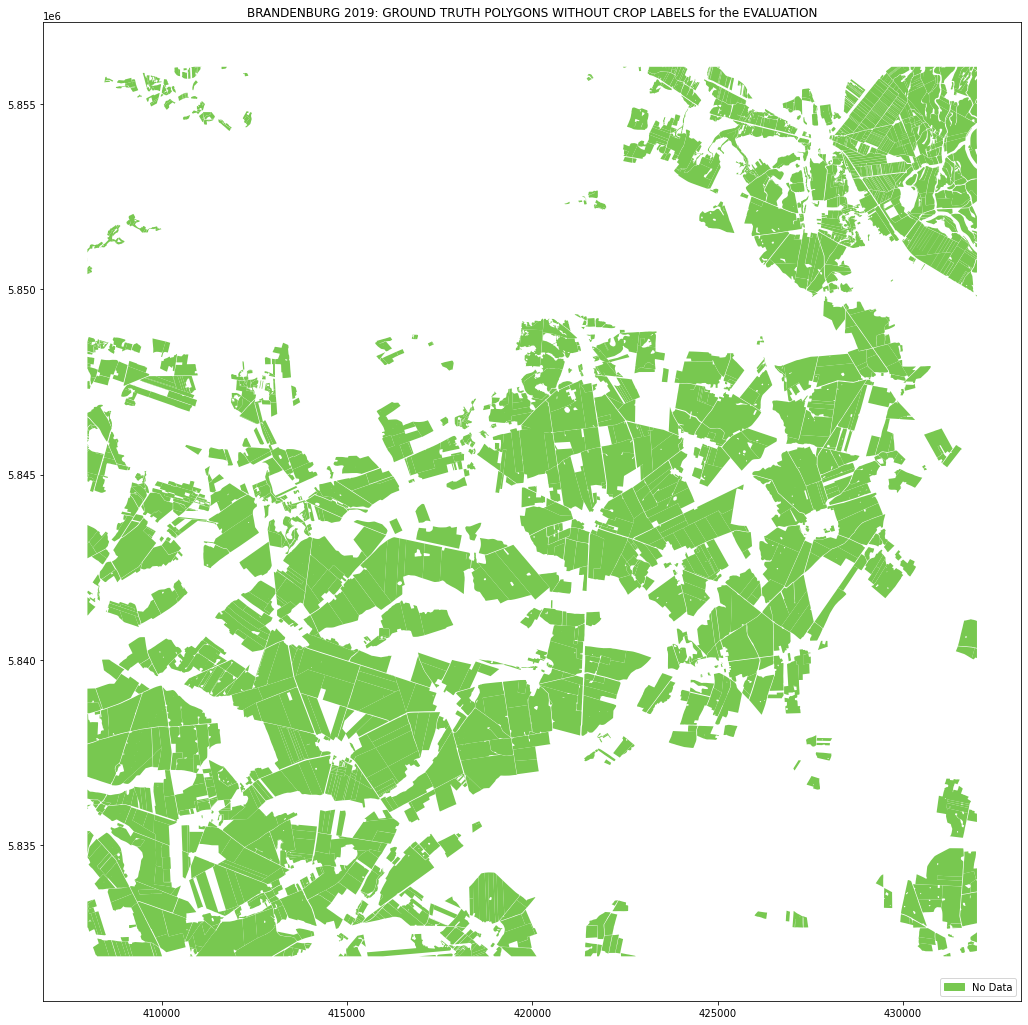

In [51]:
#DISPLAY TARGET FIELDS of 2019 WITHOUT LABELS : 

brandenburg_te=gpd.read_file(brandenburg_te_labels_dir)
fig, ax = plt.subplots(figsize=(18, 18))
counter=0
legend_elements = []
for name, group in brandenburg_te.groupby('crop_name'):
    group.plot(ax=ax,color=colors_list[counter], aspect=1)
    legend_elements.append(Patch(facecolor=colors_list[counter], edgecolor=colors_list[counter],label=name))
    counter+=1

ax.legend(handles=legend_elements,loc='lower right')
ax.title.set_text('BRANDENBURG 2019: GROUND TRUTH POLYGONS WITHOUT CROP LABELS for the EVALUATION')


### 1.2 Data Types for Brandenburg <a name="dt1"></a>

The input images are from _Sentinel-1_, _Sentinel-2_ and _Planet Fusion_, with following details: 

 * _Planet Fusion Surface Reflection_ (PF-SR) imagery contains 4 channels in total: `[blue, green, red, NIR]` channels in order, with 3-meter resolution and the provided data is in `TIFF` imaging format. To elaborate on, the Planet Fusion Monitoring product consists of clean (i.e. free from clouds and shadows), daily gap-filled, high resolution, temporally consistent, radiometrically robust, harmonized and sensor agnostic surface reflectance time series, featuring and synergizing inputs from both public and private sensor sources and directly interoperable with HLS (harmonized Landsat Sentinel) surface reflectance products. The Planet Fusion data is provided in two alternative versions: daily and with a 5-day cadence (a light-weight version composited by applying a median filter to the daily product). Participants have the option to use either. For more details, you can refer to the specifications of [PLANET FUSION]( https://assets.planet.com/docs/Planet_fusion_specification_March_2021.pdf). 

* _Sentinel-1_ (S1) imagery contains 3 channels in total: `[VV, VH, ANGLE]` where _V_ and _H_ stand for vertical and horizontal orientations, respectively, and _ANGLE_ stores the angle of observation to the earth surface as described [here](https://www.nrcan.gc.ca/maps-tools-and-publications/satellite-imagery-and-air-photos/tutorial-fundamentals-remote-sensing/microwave-remote-sensing/radar-image-distortions/9325). The data is collected in Interferometric Wide (IW) swath mode and it includes both ascending and descending orbit directions. For further information about _Sentinel-1_ imagery, please refer to [Sentinel Hub](https://docs.sentinel-hub.com/api/latest/data/sentinel-1-grd/). 


* _Sentinel-2_ (S2) includes all L2A bands in the following order `[B01, B02, B03, B04, B05, B06, B07, B08, B8A, B09, B11, B12]`. The bands that have original spatial resolution of `20m` and `60m` are interpolated with a nearest-neighbour method to a `10m` resolution. More information about the interpolation process [here](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/#processing-options). Moreover, the cloud probability mask `CLP` is also provided, for more details please refer to [Sentinel Hub](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/#available-bands-and-data).

#### 1.2.1 Explore Planet Fusion Data over Brandenburg <a name="bepfd"></a>

In [ ]:
#DIRECTORY OF PLANET FUSION TRAINING DATA AND GROUND TRUTHS:

brandenburg_planet_train_dir='data/planet/UTM-24000/33N/18E-242N/PF-SR/'
brandenburg_tr_labels_dir='data/brandenburg-gt/br-18E-242N-crop-labels-train-2018.geojson'

In [ ]:
#INITIALIZE THE DATA READER TO OBSERVE THE FIELDS FROM PLANET DATA: 

# Choose some days of the year to plot
selected_days_of_year = [10,20,30,40, 50] #from 365 days of the year

#Initialize data reader for planet images
planet_reader = PlanetReader(input_dir=brandenburg_planet_train_dir,
                                  label_dir=brandenburg_tr_labels_dir,
                                  selected_time_points=selected_days_of_year)


In [39]:
#DEFINE TRUE COLOR IMAGING AND NDVI INDEXING FUNCTIONS FOR VISUALISATION OF PLANET DATA: 

#Define NDVI index for Planet Fusion images
def ndvi(X):
    red = X[2]
    nir = X[3]
    return (nir-red) / (nir + red)

#Define True Color for Planet Fusion images
def true_color(X):
    blue = X[0]/(X[0].max()/255.0)
    green = X[1]/(X[1].max()/255.0)
    red = X[2]/(X[2].max()/255.0)
    tc = np.dstack((red,green,blue)) 
    
    return tc.astype('uint8')


In [ ]:
#VISUALISE SOME OF THE FIELDS FROM PLANET DATA: 

#Initialize plot cells
num_row = 2 * len(selected_days_of_year)
num_col = len(label_ids)
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_col,2*num_row))

#Display one sample field for each crop type
pbar = tqdm(total=len(label_ids))
iterable=iter(planet_reader)
for crop_id, crop_name in zip(label_ids,label_names):
    while True:
        # read a field sample
        X,y,mask,_ = next(iterable) 
        
        width=X.shape[-1]
        height=X.shape[-2]
        
        #Get one sample for each crop type, and
        #consider large areas (at least 200x200) to display
        if y == crop_id and width>200 and height>200:
            for i, day in enumerate(selected_days_of_year):
                
                # Display RGB image of the field in a given week for a given crop type
                ax = axes[(2*i)%num_row, crop_id%num_col]
                ax.title.set_text('{}'.format(crop_name))
                ax.set_ylabel('RGB in Day {}'.format(day))
                ax.set_xticks([])
                ax.set_yticks([])
                ax.imshow(true_color(X[i]))
                
                # Display NDVI index of the field in a given day for a given crop type
                ax = axes[(2*i+1)%num_row, crop_id%num_col]
                ax.title.set_text('{}'.format(crop_name))
                ax.set_ylabel('NDVI in Day {}'.format(day))
                ax.set_xticks([])
                ax.set_yticks([])
                ax.imshow(ndvi(X[i]*mask),cmap=plt.cm.summer)
                
            #if one sample selected for a crop type, break the WHILE loop
            pbar.set_description("Plotting {} Fields".format(crop_name))
            pbar.update(1)
            break
        
        
plt.tight_layout()
plt.show()
pbar.set_description("Plotting Complete!")
pbar.close()


#### 1.2.2 Explore Sentinel-1 Data over Brandenburg <a name="bes1d"></a>

In [ ]:
#DIRECTORY OF SENTINEL-1 TRAINING DATA :

brandenburg_s1_asc_train_dir = "data/sentinel-1/s1-asc-utm-33N-18E-242N-2018.zip" #ASCENDING ORBIT
brandenburg_s1_dsc_train_dir = "data/sentinel-1/s1-dsc-utm-33N-18E-242N-2018.zip" #DESCENDING ORBIT

In your training and testing, you can utilize both ascending and descending orbit data. However, in this notebook, we will only demonstrate ascending orbit data. Changing the `input_dir` of `S1Reader` in the following cell is sufficient to explore descending orbit data.

In [ ]:
#INITIALIZE THE DATA READER TO OBSERVE THE FIELDS FROM S1 DATA: 

# Choose some days of the year to plot
selected_data_indices = [10,20,30,40,50] #beware that S1 data is not daily, 

#Initialize data reader for planet images
s1_reader = S1Reader(input_dir=brandenburg_s1_asc_train_dir,
                                  label_dir=brandenburg_tr_labels_dir,
                                  selected_time_points=selected_data_indices)



In [ ]:
# DEFINE RADAR VEGETATION INDEXING FOR VISUALISATION OF  S1 DATA: 
# for the algorithm please refer to Sentinel Hub: 
# https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-1/radar_vegetation_index_code_dual_polarimetric/

def rvi(X):
    VV = X[0]
    VH = X[1]
    dop = (VV/(VV+VH))
    m = 1 - dop
    radar_vegetation_index = (np.sqrt(dop))*((4*(VH))/(VV+VH))
    
    return radar_vegetation_index


In [ ]:
#VISUALISE SOME OF THE FIELDS FROM S1 DATA: 

#Initialize plot cells
num_row = len(selected_data_indices)
num_col = len(label_ids)
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_col,2*num_row))

#Display one sample field for each crop type
pbar = tqdm(total=len(label_ids))
iterable=iter(s1_reader)
for crop_id, crop_name in zip(label_ids,label_names):
    while True:
        # read a field sample
        X,y,mask,_ = next(iterable) 
        
        width=X.shape[-1]
        height=X.shape[-2]
        
        #Get one sample for each crop type, and
        #consider large areas (at least 60x60) to display
        if y == crop_id and width>60 and height>60:
            for i, day in enumerate(selected_data_indices):
                 
                # Display RVI index of the field in a given day for a given crop type
                ax = axes[i%num_row, crop_id%num_col]
                ax.title.set_text('{}'.format(crop_name))
                ax.set_ylabel('RVI in Day {}'.format(day))
                ax.set_xticks([])
                ax.set_yticks([])
                ax.imshow(rvi(X[i]*mask),cmap=plt.cm.summer)
                
            #if one sample selected for a crop type, break the WHILE loop
            pbar.set_description("Plotting {} Fields".format(crop_name))
            pbar.update(1)
            break
        
        
plt.tight_layout()
plt.show()
pbar.set_description("Plotting Complete!")
pbar.close()


#### 1.2.3 Explore Sentinel-2 Data over Brandenburg <a name="bes2d"></a>

_Sentinel-2_ (S2) can be initialized and called as similar to _Sentinel-1_ as demonstrated above. The only difference, you need to change the data reader from `S1Reader` to `S2Reader` and change the data links accordingly  as shown below. If you get an error during the initialization of the `S2Reader` it might be due to unsufficient memory in your working environment because _Sentinel-2_ data at `data/sentinel-2/s2-utm-33N-18E-242N-2018.zip` is about 12GB:

In [41]:
#DIRECTORY OF SENTINEL-2 TRAINING DATA :

brandenburg_s2_train_dir = "data/sentinel-2/s2-utm-33N-18E-242N-2018.zip"

In [ ]:
#INITIALIZE THE DATA READER TO OBSERVE THE FIELDS FROM PLANET DATA: 

# Choose some days of the year to plot
selected_data_indices = [10,20,30,40,50] #beware that S1 data is not daily, 

#Initialize data reader for planet images
s2_reader = S2Reader(input_dir=brandenburg_s2_train_dir,
                                  label_dir=brandenburg_tr_labels_dir,
                                  selected_time_points=selected_data_indices)

### 1.3 Area of Interest for South Africa <a name="aoi3"></a>

In order to check the AOI for South Africa, you can start with the ground-truth files: 
* _sa-19E-258N-crop-labels-train-2017.geojson_ -> For Training and Validation 
* _sa-19E-259N-crop-labels-train-2017.geojson_ -> For Training and Validation 
* _sa-20E-259N-crop-labels-test-2017.geojson_  -> For Test 

After your download, it is supposed to be placed in `data` folder of this notebook:

In [20]:
south_africa_tr_labels_dir_1='data/south-africa-gt/sa-19E-258N-crop-labels-train-2017.geojson'
south_africa_tr_labels_dir_2='data/south-africa-gt/sa-19E-259N-crop-labels-train-2017.geojson'
south_africa_te_labels_dir ='data/south-africa-gt/sa-20E-259N-crop-labels-test-2017.geojson'


In order to explore data types in the ground truth at `19E-258N` and  `19E-259N` (`for training`), you can run the following cell. It will summarize the `geojson` data belonging to the AOI, which have 1715 entries in the first ground-truth and 2436 entries in the second ground-truth, and 5 columns representing field ID, area of the field in square meters, length of the field in meters, crop ID, crop name and the geomtry of the field as polygon:  

In [21]:
#CHECK TARGET DATA FORMAT IN TRAINING GROUND-TRUTH POLYGONS:

south_africa_tr_labels_1=gpd.read_file(south_africa_tr_labels_dir_1)
print('INFO: Number of fields: {}\n'.format(len(south_africa_tr_labels_1)))
south_africa_tr_labels_1.info()
south_africa_tr_labels_1.tail()


INFO: Number of fields: 1715

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1715 entries, 0 to 1714
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   fid         1715 non-null   int64   
 1   SHAPE_AREA  1715 non-null   float64 
 2   SHAPE_LEN   1715 non-null   float64 
 3   crop_id     1715 non-null   int64   
 4   crop_name   1715 non-null   object  
 5   geometry    1715 non-null   geometry
dtypes: float64(2), geometry(1), int64(2), object(1)
memory usage: 80.5+ KB


fid     SHAPE_AREA    SHAPE_LEN  crop_id            crop_name  \
1710  272638  237553.921793  2062.209147        2               Barley   
1711  272639  142707.098365  2524.575182        1                Wheat   
1712  272759   14774.502277  1020.000876        5  Small grain grazing   
1713  272760   14323.177324   704.568254        4       Lucerne/Medics   
1714  272762  106682.754574  1482.252585        4       Lucerne/Medics   

                                               geometry  
1710  MULTIPOLYGON (((479711.541 6214292.977, 479705...  
1711  MULTIPOLYGON (((477055.645 6199524.810, 477037...  
1712  MULTIPOLYGON (((465387.091 6197134.178, 465380...  
1713  MULTIPOLYGON (((463318.045 6200831.958, 463306...  
1714  MULTIPOLYGON (((462690.755 6200783.963, 462469...

In [22]:
#CHECK TARGET DATA FORMAT IN TRAINING GROUND-TRUTH POLYGONS:

south_africa_tr_labels_2=gpd.read_file(south_africa_tr_labels_dir_2)
print('INFO: Number of fields: {}\n'.format(len(south_africa_tr_labels_2)))
south_africa_tr_labels_2.info()
south_africa_tr_labels_2.tail()

INFO: Number of fields: 2436

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2436 entries, 0 to 2435
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   fid         2436 non-null   int64   
 1   SHAPE_AREA  2436 non-null   float64 
 2   SHAPE_LEN   2436 non-null   float64 
 3   crop_id     2436 non-null   int64   
 4   crop_name   2436 non-null   object  
 5   geometry    2436 non-null   geometry
dtypes: float64(2), geometry(1), int64(2), object(1)
memory usage: 114.3+ KB


fid     SHAPE_AREA    SHAPE_LEN  crop_id       crop_name  \
2431  270980  103201.583620  1167.637967        4  Lucerne/Medics   
2432  271186   29028.409640  1339.613960        4  Lucerne/Medics   
2433  271187    1756.641790   186.496241        4  Lucerne/Medics   
2434  271188    6319.516614   496.304342        4  Lucerne/Medics   
2435  271189    5078.729177   432.672236        4  Lucerne/Medics   

                                               geometry  
2431  MULTIPOLYGON (((456615.950 6227562.739, 456606...  
2432  MULTIPOLYGON (((456726.354 6227938.500, 456730...  
2433  MULTIPOLYGON (((456476.993 6227877.458, 456469...  
2434  MULTIPOLYGON (((456496.040 6227596.795, 456502...  
2435  MULTIPOLYGON (((456699.919 6227590.255, 456687...

In order to explore data types in the ground truth at `20E-259N` (`for the evaluation of challenge`), you can run the following cell. It will summarize the `geojson` data belonging to the AOI, which have 2417 entries, and 5 columns representing field ID, area of the field in square meters, length of the field in meters, crop ID, crop name and the geomtry of the field as polygon, as same with the example above. However the column `crop_id` has always value _0_, and `crop_name` is only _No Data_, because they are reserved for the evaluation of the challenge. Participants of the challenge can only benefit from the `geometry` column to make predictions for each field bounded by a polygon:

In [23]:
#CHECK TARGET DATA FORMAT IN EVALUATION GROUND-TRUTH POLYGONS:

south_africa_te_labels=gpd.read_file(south_africa_te_labels_dir)
print('INFO: Number of fields: {}\n'.format(len(south_africa_te_labels)))
south_africa_te_labels.info()
south_africa_te_labels.tail()


INFO: Number of fields: 2417

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2417 entries, 0 to 2416
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   fid         2417 non-null   int64   
 1   SHAPE_AREA  2417 non-null   float64 
 2   SHAPE_LEN   2417 non-null   float64 
 3   crop_id     2417 non-null   int64   
 4   crop_name   2417 non-null   object  
 5   geometry    2417 non-null   geometry
dtypes: float64(2), geometry(1), int64(2), object(1)
memory usage: 113.4+ KB


fid     SHAPE_AREA    SHAPE_LEN  crop_id crop_name  \
2412  272354  126740.775270  1459.240753        0   No Data   
2413  272355  144071.881716  1562.941091        0   No Data   
2414  272429   44331.637211   836.115387        0   No Data   
2415  272640  345984.933132  2934.752582        0   No Data   
2416  272740    7384.029432   348.852724        0   No Data   

                                               geometry  
2412  MULTIPOLYGON (((494072.643 6234366.595, 493923...  
2413  MULTIPOLYGON (((497143.580 6229113.759, 497128...  
2414  MULTIPOLYGON (((493125.600 6234793.677, 493111...  
2415  MULTIPOLYGON (((487221.594 6224539.396, 487737...  
2416  MULTIPOLYGON (((485258.535 6221836.838, 485196...

When you look at the crop labels and crop names in training ground-truths you are supposed to see 5 crop types with the following IDs:
 * 1: Wheat
 * 2: Barley
 * 3: Canola
 * 4: Lucerne/Medics
 * 5: Small grain grazing

In [25]:
#CHECK LABEL IDs AND LABEL NAMES: 

label_ids=south_africa_tr_labels_2['crop_id'].unique()
label_names=south_africa_tr_labels_2['crop_name'].unique()

print('INFO: Label IDs: {}'.format(label_ids))
print('INFO: Label Names: {}'.format(label_names))

INFO: Label IDs: [4 2 5 1 3]
INFO: Label Names: ['Lucerne/Medics' 'Barley' 'Small grain grazing' 'Wheat' 'Canola']


These plant types are not evenly planted in the agricultural fields, so you can observe the distribution of fields with each particular crop as below: 

INFO: Number of Fields by Crop Type: 
Lucerne/Medics         1792
Wheat                   753
Canola                  512
Barley                  661
Small grain grazing     433
Name: crop_name, dtype: int64


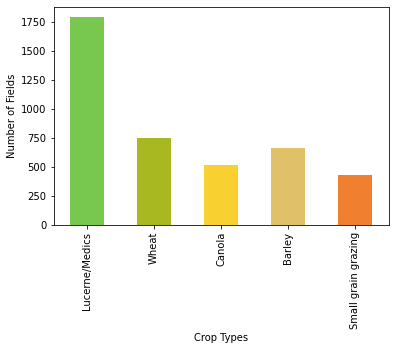

In [26]:
#CHECK FIELD DISTRIBUTION BY LABEL: 

value_counts =south_africa_tr_labels_1['crop_name'].value_counts()
value_counts += south_africa_tr_labels_2['crop_name'].value_counts()

colors_list = ['#78C850','#A8B820','#F8D030','#E0C068', '#F08030', '#C03028', '#F85888','#6890F0','#98D8D8'] 
ax=value_counts.plot.bar(color=colors_list)
ax.set_ylabel("Number of Fields")
ax.set_xlabel("Crop Types")

print('INFO: Number of Fields by Crop Type: \n{}'.format(value_counts))

However, if we look at the per hectare distribution of each crop, we will see a different distribution, because some crops seem usually planted in larger areas:

INFO: Total Hectare per Crop Type: 
                   crop_name  total_hectare
crop_id                                    
1.0                    Wheat   14060.633983
2.0                   Barley   11491.487593
3.0                   Canola    9889.008658
4.0           Lucerne/Medics   20795.063533
5.0      Small grain grazing    6013.529840


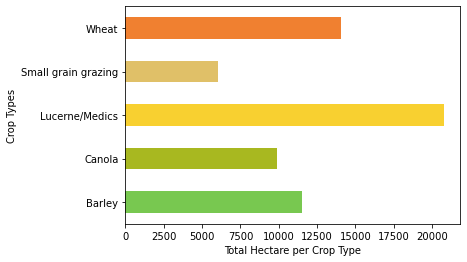

In [27]:
#CHECK TOTAL HECTARE DISTRIBUTION BY LABEL: 

hectare_distribution = pd.DataFrame(columns=["crop_name", "total_hectare"])
for group_1, group_2 in zip(south_africa_tr_labels_1.groupby('crop_name'),
                                        south_africa_tr_labels_2.groupby('crop_name')):
    crop_id=group_1[1].iloc[0]['crop_id']
    crop_name=group_1[0]
    total_hectare_1=group_1[1]['SHAPE_AREA'].sum()/10000 # convert to m2 to hectare
    total_hectare_2=group_2[1]['SHAPE_AREA'].sum()/10000 # convert to m2 to hectare
    total_hectare= total_hectare_1 + total_hectare_2
    
    hectare_distribution=hectare_distribution.append({'crop_id':crop_id, 'crop_name':crop_name, 'total_hectare':total_hectare}, ignore_index=True)

hectare_distribution.set_index('crop_id', inplace=True)
colors_list = ['#78C850','#A8B820','#F8D030','#E0C068', '#F08030', '#C03028', '#F85888','#6890F0','#98D8D8'] 
ax=hectare_distribution.plot.barh(color=colors_list,x='crop_name', y='total_hectare',legend=False)
ax.set_xlabel("Total Hectare per Crop Type")
ax.set_ylabel("Crop Types")

print('INFO: Total Hectare per Crop Type: \n{}'.format(hectare_distribution.sort_index()))

For South Africa, the ground-truths at tiles `19E-258N` and  `19E-259N` as can be observed below:

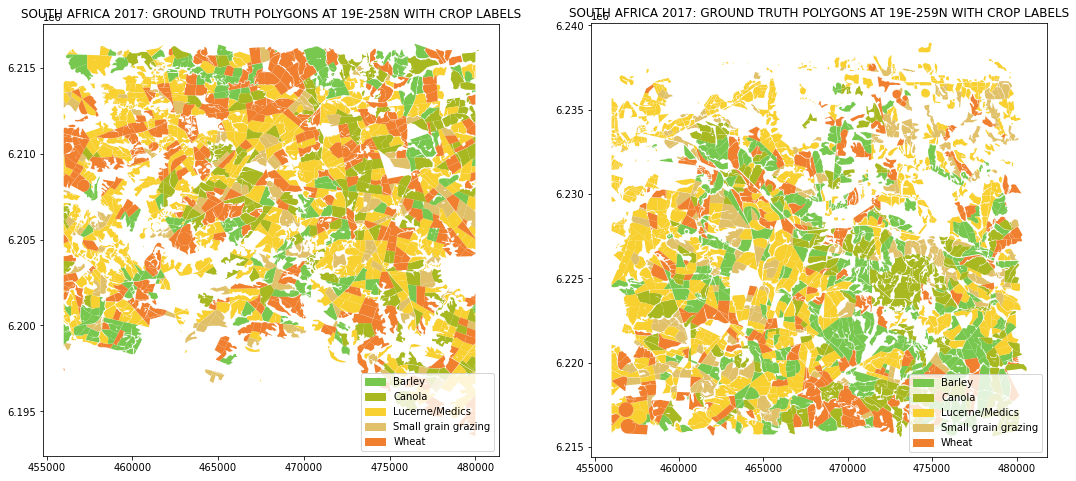

In [28]:
#DISPLAY TARGET FIELDS AT TILES '19E-258N' and '19E-259N' FOR TRAINING ON THE MAP BY LABEL: 

fig, axes = plt.subplots(1,2, figsize=(18, 18))
counter=0
legend_elements = []
for group_1, group_2 in zip(south_africa_tr_labels_1.groupby('crop_name'),
                            south_africa_tr_labels_2.groupby('crop_name')):
    
    group_1[1].plot(ax=axes[0],color=colors_list[counter], aspect=1)
    group_2[1].plot(ax=axes[1],color=colors_list[counter], aspect=1)
    
    legend_elements.append(Patch(facecolor=colors_list[counter], edgecolor=colors_list[counter],label=group_1[0]))
    counter+=1


axes[0].legend(handles=legend_elements,loc='lower right')
axes[0].title.set_text('SOUTH AFRICA 2017: GROUND TRUTH POLYGONS AT 19E-258N WITH CROP LABELS')

axes[1].legend(handles=legend_elements,loc='lower right')
axes[1].title.set_text('SOUTH AFRICA 2017: GROUND TRUTH POLYGONS AT 19E-259N WITH CROP LABELS')

For South Africa, the ground-truths at tile 20E-259N as can be observed below, however as you can notice, only polygons are given to you without crop names and crop IDs, because they are reserved for the evaluation of challenge. 

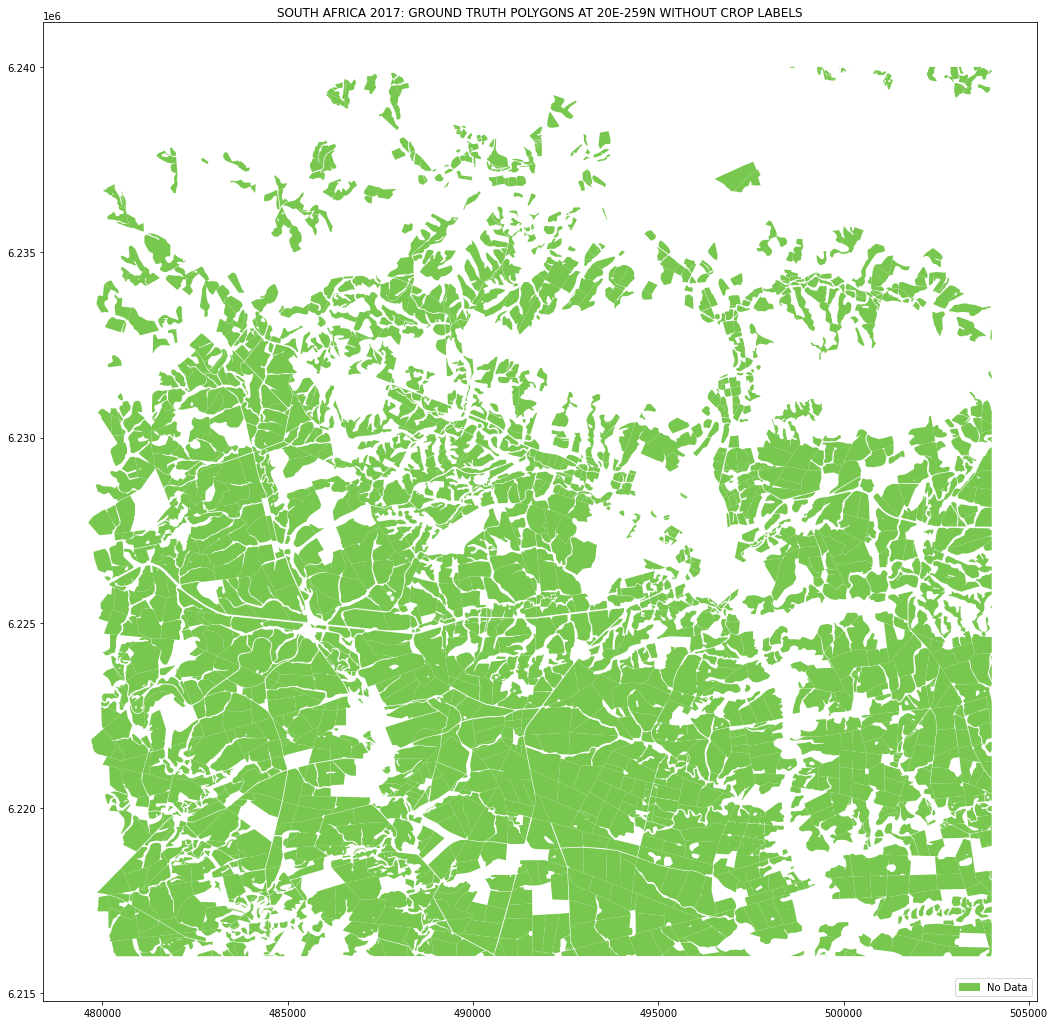

In [29]:
#DISPLAY TARGET FIELDS AT TILES '20E-259N' WITHOUT LABELS : 

south_africa_te_labels=gpd.read_file(south_africa_te_labels_dir)
fig, ax = plt.subplots(figsize=(18, 18))
counter=0
legend_elements = []
for name, group in south_africa_te_labels.groupby('crop_name'):
    group.plot(ax=ax,color=colors_list[counter], aspect=1)
    legend_elements.append(Patch(facecolor=colors_list[counter], edgecolor=colors_list[counter],label=name))
    counter+=1

ax.legend(handles=legend_elements,loc='lower right')
ax.title.set_text('SOUTH AFRICA 2017: GROUND TRUTH POLYGONS AT 20E-259N WITHOUT CROP LABELS')

### 1.4 Data Types for South Africa <a name="dt2"></a>

The input images are from _Sentinel-1_, _Sentinel-2_ and _Planet Fusion_, with following details: 

 * _Planet Fusion Surface Reflection_ (PF-SR) imagery contains 4 channels in total: `[blue, green, red, NIR]` channels in order, with 3-meter resolution and the provided data is in `TIFF` imaging format. To elaborate on, the Planet Fusion Monitoring product consists of clean (i.e. free from clouds and shadows), daily gap-filled, high resolution, temporally consistent, radiometrically robust, harmonized and sensor agnostic surface reflectance time series, featuring and synergizing inputs from both public and private sensor sources and directly interoperable with HLS (harmonized Landsat Sentinel) surface reflectance products. The Planet Fusion data is provided in two alternative versions: daily and with a 5-day cadence (a light-weight version composited by applying a median filter to the daily product). Participants have the option to use either. For more details, you can refer to the specifications of [PLANET FUSION]( https://assets.planet.com/docs/Planet_fusion_specification_March_2021.pdf). 

* _Sentinel-1_ (S1) imagery contains 3 channels in total: `[VV, VH, ANGLE]` where _V_ and _H_ stand for vertical and horizontal orientations, respectively, and _ANGLE_ stores the angle of observation to the earth surface as described [here](https://www.nrcan.gc.ca/maps-tools-and-publications/satellite-imagery-and-air-photos/tutorial-fundamentals-remote-sensing/microwave-remote-sensing/radar-image-distortions/9325). The data is collected in Interferometric Wide (IW) swath mode and it includes both ascending and descending orbit directions. For further information about _Sentinel-1_ imagery, please refer to [Sentinel Hub](https://docs.sentinel-hub.com/api/latest/data/sentinel-1-grd/). 


* _Sentinel-2_ (S2) includes all L2A bands in the following order `[B01, B02, B03, B04, B05, B06, B07, B08, B8A, B09, B11, B12]`. The bands that have original spatial resolution of `20m` and `60m` are interpolated with a nearest-neighbour method to a `10m` resolution. More information about the interpolation process [here](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/#processing-options). Moreover, the cloud probability mask `CLP` is also provided, for more details please refer to [Sentinel Hub](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/#available-bands-and-data).

#### 1.4.1 Explore Planet Fusion Data over South Africa <a name="bepfd"></a>

In [36]:
#DIRECTORY OF PLANET FUSION TRAINING DATA AND LABELS:

south_africa_planet_train_dir_1='data/planet/UTM-24000/34S/19E-258N/PF-SR/'
south_africa_tr_labels_dir_1='data/south-africa-gt/sa-19E-258N-crop-labels-train-2017.geojson'

south_africa_planet_train_dir_2='data/planet/UTM-24000/34S/19E-259N/PF-SR/'
south_africa_tr_labels_dir_2='data/south-africa-gt/sa-19E-259N-crop-labels-train-2017.geojson'

In [37]:
#INITIALIZE THE DATA READER TO OBSERVE THE FIELDS FROM PLANET DATA: 

# Choose some days of the year to plot
selected_days_of_year = [1, 2, 3, 4, 5] #from 244 days of the year

#Initialize data reader for planet images
planet_reader = PlanetReader(input_dir=south_africa_planet_train_dir_1,
                                  label_dir=south_africa_tr_labels_dir_1,
                                  selected_time_points=selected_days_of_year)

INFO: Coordinate system of the data is: EPSG:32734
INFO: Ignoring 3/1715 fields with area < 1000m2


INFO: Extracting time series into the folder: /local_home/kuzu_ri/GIT_REPO/starter-pack-ai4food-v0.0.1/notebook/data/planet/UTM-24000/34S/19E-258N/PF-SR/time_series: 100%|██████████| 1712/1712 [03:07<00:00,  9.14it/s]


  0%|          | 0/5 [00:00<?, ?it/s]

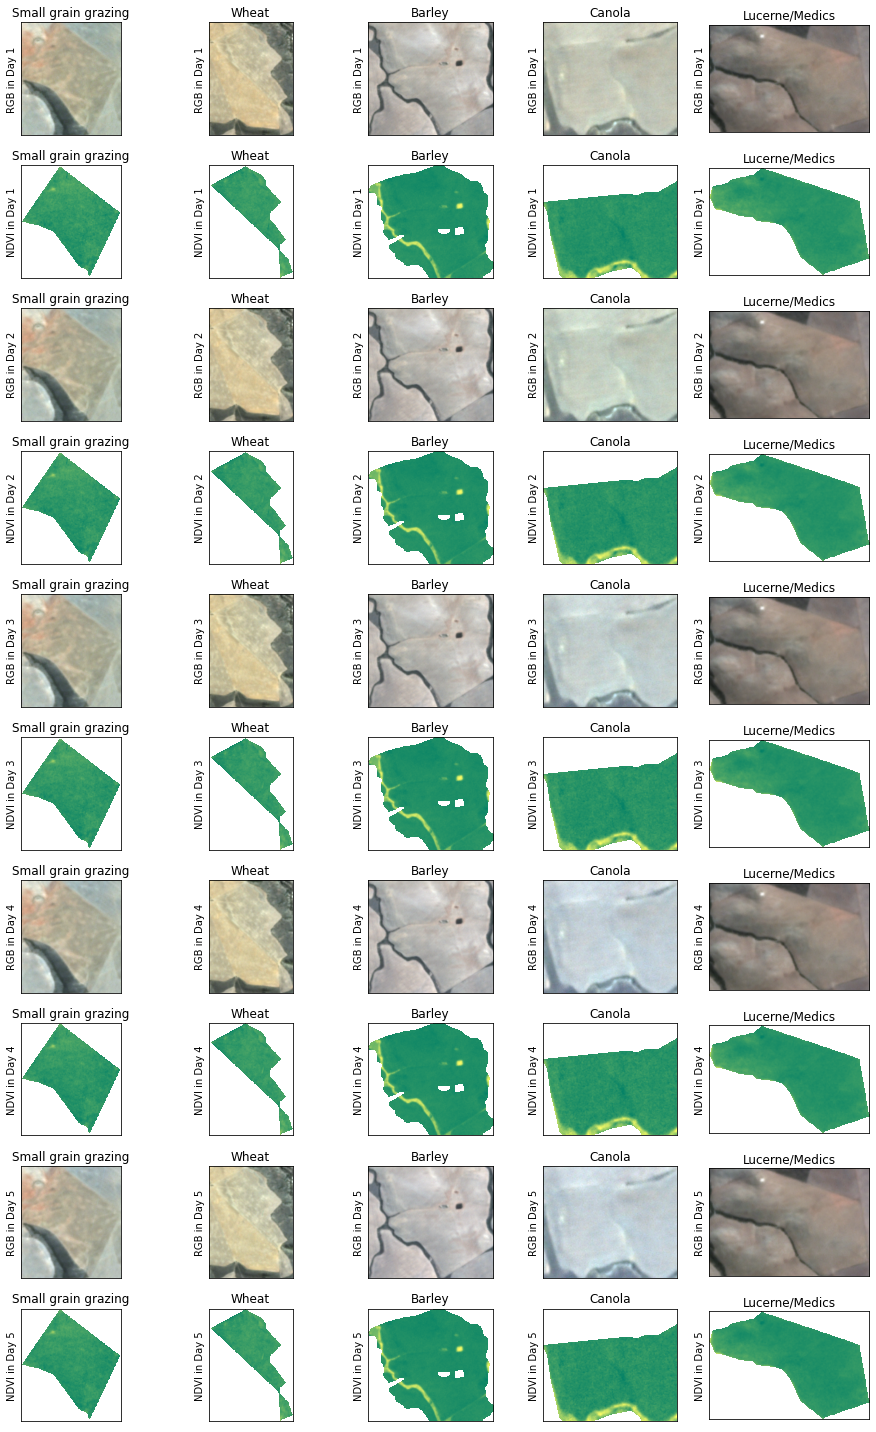

In [40]:
#VISUALISE SOME OF THE FIELDS FROM PLANET DATA: 

#Initialize plot cells
num_row = 2 * len(selected_days_of_year)
num_col = len(label_ids)
fig, axes = plt.subplots(num_row, num_col, figsize=(2.5*num_col,2*num_row))

#Display one sample field for each crop type
pbar = tqdm(total=len(label_ids))
iterable=iter(planet_reader)
for crop_id, crop_name in zip(label_ids,label_names):
    while True:
        # read a field sample
        X,y,mask,fid = next(iterable) 
        
        width=X.shape[-1]
        height=X.shape[-2]
        
        #Get one sample for each crop type, and
        #consider large areas (at least 200x200) to display
        if y == crop_id and width>200 and height>200:
            for i, day in enumerate(selected_days_of_year):
                
                # Display RGB image of the field in a given week for a given crop type
                ax = axes[(2*i)%num_row, crop_id%num_col]
                ax.title.set_text('{}'.format(crop_name))
                ax.set_ylabel('RGB in Day {}'.format(day))
                ax.set_xticks([])
                ax.set_yticks([])
                ax.imshow(true_color(X[i]))
                
                # Display NDVI index of the field in a given day for a given crop type
                ax = axes[(2*i+1)%num_row, crop_id%num_col]
                ax.title.set_text('{}'.format(crop_name))
                ax.set_ylabel('NDVI in Day {}'.format(day))
                ax.set_xticks([])
                ax.set_yticks([])
                ax.imshow(ndvi(X[i]*mask),cmap=plt.cm.summer)
                
            #if one sample selected for a crop type, break the WHILE loop
            pbar.set_description("Plotting {} Fields".format(crop_name))
            pbar.update(1)
            break
        
        
plt.tight_layout()
plt.show()
pbar.set_description("Plotting Complete!")
pbar.close()

#### 1.4.2 Explore Sentinel-1 Data over South Africa <a name="ses1d"></a>

In [35]:
#DIRECTORY OF SENTINEL-1 TRAINING DATA:

south_africa_s1_asc_train_dir_1 = "data/sentinel-1/s1-asc-utm-34S-19E-258N-2017.zip"
south_africa_s1_asc_train_dir_2 = "data/sentinel-1/s1-asc-utm-34S-19E-259N-2017.zip"

In [36]:
#INITIALIZE THE DATA READER TO OBSERVE THE FIELDS FROM S1 DATA: 

# Choose some days of the year to plot
selected_data_indices = [10,15,20,25,30] #beware that S1 data is not daily, 

#Initialize data reader for planet images
s1_reader = S1Reader(input_dir=south_africa_s1_asc_train_dir_1,
                                  label_dir=south_africa_tr_labels_dir_1,
                                  selected_time_points=selected_data_indices)

INFO: Found folder in data/sentinel-1/s1-asc-utm-34S-19E-258N-2017, no need to unzip
INFO: Ignoring 3/1715 fields with area < 1000m2


INFO: Extracting time series into the folder: data/sentinel-1/s1-asc-utm-34S-19E-258N-2017/time_series: 100%|██████████| 1712/1712 [00:00<00:00, 6350.32it/s]


  0%|          | 0/5 [00:00<?, ?it/s]

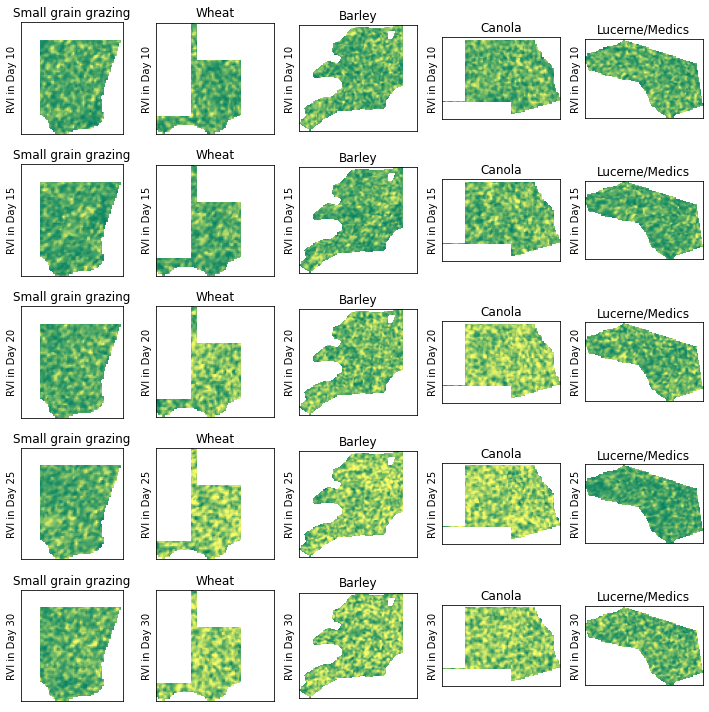

In [37]:
#VISUALISE SOME OF THE FIELDS FROM S1 DATA: 

#Initialize plot cells
num_row = len(selected_data_indices)
num_col = len(label_ids)
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_col,2*num_row))

#Display one sample field for each crop type
pbar = tqdm(total=len(label_ids))
iterable=iter(s1_reader)
for crop_id, crop_name in zip(label_ids,label_names):
    while True:
        # read a field sample
        X,y,mask,fid = next(iterable) 
        width=X.shape[-1]
        height=X.shape[-2]
        
        #Get one sample for each crop type, and
        #consider large areas (at least 60x60) to display
        if y == crop_id and width>60 and height>60:
            for i, day in enumerate(selected_data_indices):
                 
                # Display RVI index of the field in a given day for a given crop type
                ax = axes[i%num_row, crop_id%num_col]
                ax.title.set_text('{}'.format(crop_name))
                ax.set_ylabel('RVI in Day {}'.format(day))
                ax.set_xticks([])
                ax.set_yticks([])
                ax.imshow(rvi(X[i]*mask),cmap=plt.cm.summer)
                
            #if one sample selected for a crop type, break the WHILE loop
            pbar.set_description("Plotting {} Fields".format(crop_name))
            pbar.update(1)
            break
        
        
plt.tight_layout()
plt.show()
pbar.set_description("Plotting Complete!")
pbar.close()

#### 1.4.3 Explore Sentinel-2 Data over South Africa <a name="ses2d"></a>

In [38]:
#DIRECTORY OF SENTINEL-2 TRAINING DATA:

south_africa_s2_train_dir_1 = "data/sentinel-2/s2-utm-34S-19E-258N-2017.zip"
south_africa_s2_train_dir_2 = "data/sentinel-2/s2-utm-34S-19E-259N-2017.zip"

In [39]:
#INITIALIZE THE DATA READER TO OBSERVE THE FIELDS FROM S2 DATA: 

# Choose some days of the year to plot
selected_data_indices = [12,18,24,30,36] #beware that S2 data is not daily, 

#Initialize data reader for planet images
s2_reader = S2Reader(input_dir=south_africa_s2_train_dir_1,
                                  label_dir=south_africa_tr_labels_dir_1,
                                  selected_time_points=selected_data_indices)

INFO: Found folder in data/sentinel-2/s2-utm-34S-19E-258N-2017, no need to unzip
INFO: Ignoring 3/1715 fields with area < 1000m2


INFO: Extracting time series into the folder: data/sentinel-2/s2-utm-34S-19E-258N-2017/time_series: 100%|██████████| 1712/1712 [00:00<00:00, 7886.99it/s]


In [40]:
#DEFINE TRUE COLOR IMAGING AND NDVI INDEXING FUNCTIONS FOR VISUALISATION OF S2 DATA: 

#Define NDVI index for S2 images
def ndvi(X):
    red = X[3]
    nir = X[7]
    return (nir-red) / (nir + red)

#Define True Color for S2 images
def true_color(X):
    blue = X[1]/(X[1].max()/255.0)
    green = X[2]/(X[2].max()/255.0)
    red = X[3]/(X[3].max()/255.0)
    tc = np.dstack((red,green,blue)) 
    
    return tc.astype('uint8')


  0%|          | 0/5 [00:00<?, ?it/s]

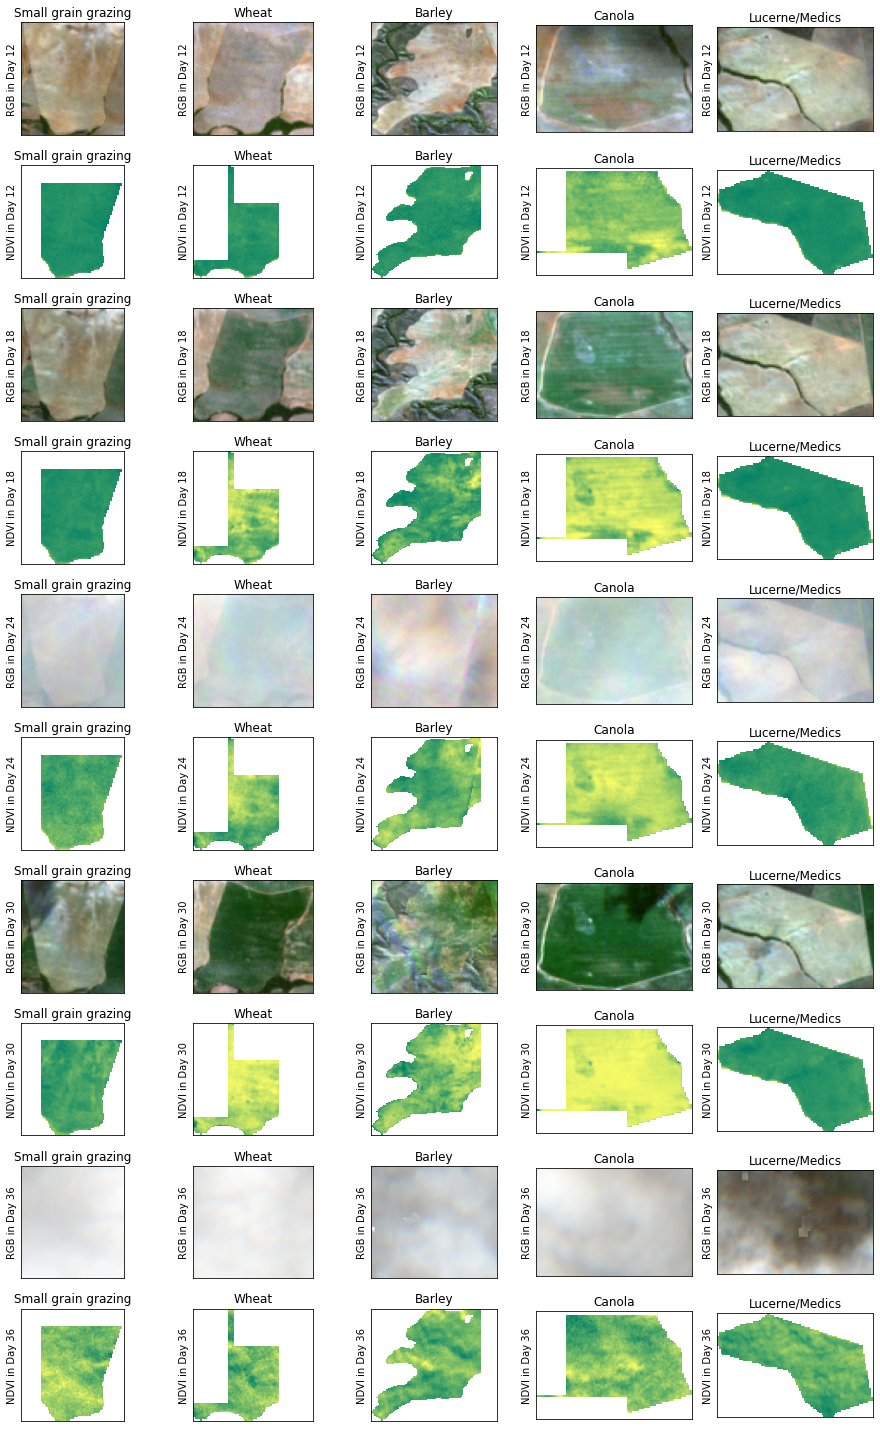

In [41]:
#VISUALISE SOME OF THE FIELDS FROM S2 DATA: 

#Initialize plot cells
num_row = 2 * len(selected_days_of_year)
num_col = len(label_ids)
fig, axes = plt.subplots(num_row, num_col, figsize=(2.5*num_col,2*num_row))

#Display one sample field for each crop type
pbar = tqdm(total=len(label_ids))
iterable=iter(s2_reader)
for crop_id, crop_name in zip(label_ids,label_names):
    while True:
        # read a field sample
        X,y,mask,fid = next(iterable) 
        
        width=X.shape[-1]
        height=X.shape[-2]
        
        #Get one sample for each crop type, and
        #consider large areas (at least 60x60) to display
        if y == crop_id and width>60 and height>60:
            for i, day in enumerate(selected_data_indices):
                
                # Display RGB image of the field in a given week for a given crop type
                ax = axes[(2*i)%num_row, crop_id%num_col]
                ax.title.set_text('{}'.format(crop_name))
                ax.set_ylabel('RGB in Day {}'.format(day))
                ax.set_xticks([])
                ax.set_yticks([])
                ax.imshow(true_color(X[i]))
                
                # Display NDVI index of the field in a given day for a given crop type
                ax = axes[(2*i+1)%num_row, crop_id%num_col]
                ax.title.set_text('{}'.format(crop_name))
                ax.set_ylabel('NDVI in Day {}'.format(day))
                ax.set_xticks([])
                ax.set_yticks([])
                ax.imshow(ndvi(X[i]*mask),cmap=plt.cm.summer)
                
            #if one sample selected for a crop type, break the WHILE loop
            pbar.set_description("Plotting {} Fields".format(crop_name))
            pbar.update(1)
            break
        
        
plt.tight_layout()
plt.show()
pbar.set_description("Plotting Complete!")
pbar.close()

Please note that some of the true color views of agricultural fields observed above have been occluded with high level of clouds. You are free to use cloud probability mask `CLP` provided with _Sentinel-2_ as you can see how to reach it in file `notebook/utils/sentinel_2_reader.py` of this project. 

## 2. Data Processing and ML Training <a name="data-processing"></a>

This section offers some tips and pointers on how to possibly transform the data in a ML-ready format and build a sample ML model. Implementations here are mainly based on the approach in following paper: 

Kondmann, Lukas, et al. (2021), 
[DENETHOR: The DynamicEarthNET dataset for Harmonized, inter-Operable, analysis-Ready, daily crop monitoring](https://openreview.net/pdf?id=uUa4jNMLjrL)

Please note that the below examples about data reading, data augmentation and ML training are based on standalone usage of each data sources (i.e. exploiting only _Planet Fusion_ or _Sentinel-2_), but you are free to implement any processing pipeline to utilize the fusion/ensemble approaches on data level, feature level or decision level. 


If you want to use `eo-learn` for these tasks, check out the documentation about existing tasks like filtering and pixel sampling [here](https://eo-learn.readthedocs.io/en/latest/eotasks.html). You can easily implement your own task (as done above) by following [this example](https://eo-learn.readthedocs.io/en/latest/examples/core/CoreOverview.html#EOTask). [Here](https://github.com/sentinel-hub/eo-learn/tree/master/examples) you can find a collection of examples including land cover and crop-type classification.

### 2.1 Exploiting _Planet Fusion_ Data <a name="epfd"></a>

The following example initializes and trains a field-based crop-type classification model utilizing _Planet Fusion_ data over Brandenburg area. However, by changing the type of data reader (i.e. from `PlanetReader` to `S1Reader` or `S2Reader`) and changing the training data directories, you can do the same training for other AOIs with different data sources. The example data readers are given under `notebook/utils/` of this project:

In [42]:
#LET'S RECALL NECESSARY DIRECTORIES FOR TRAINING ON BRANDENBURG AREA: 

brandenburg_planet_train_dir='data/planet/UTM-24000/33N/18E-242N/PF-SR/'
brandenburg_tr_labels_dir='data/brandenburg-gt/br-18E-242N-crop-labels-train-2018.geojson'

brandenburg_tr_labels=gpd.read_file(brandenburg_tr_labels_dir)

label_ids=brandenburg_tr_labels['crop_id'].unique()
label_names=brandenburg_tr_labels['crop_name'].unique()

In [43]:
#INITIALIZE DATA LOADERS FOR TRAINING AND EVALUATION: 

#Get data transformer for planet images
planet_transformer=PlanetTransform()

#Initialize data reader for planet images
planet_reader = PlanetReader(input_dir=brandenburg_planet_train_dir,
                             label_dir=brandenburg_tr_labels_dir,
                             label_ids=label_ids,
                             transform=planet_transformer.transform,
                             min_area_to_ignore=1000)

#Initialize data loaders
data_loader=DataLoader(train_val_reader=planet_reader, validation_split=0.25)
train_loader=data_loader.get_train_loader(batch_size=8, num_workers=1)
valid_loader=data_loader.get_validation_loader(batch_size=8, num_workers=1)


INFO: Coordinate system of the data is: EPSG:32633
INFO: Ignoring 30/2534 fields with area < 1000m2


INFO: Extracting time series into the folder: /local_home/kuzu_ri/GIT_REPO/starter-pack-ai4food-v0.0.1/notebook/data/planet/UTM-24000/33N/18E-242N/PF-SR/time_series: 100%|██████████| 2504/2504 [00:00<00:00, 4264.66it/s]

INFO: Training data loader initialized.
INFO: Validation data loader initialized.


In [44]:
#INITIALIZE TRAINING MODEL: 

INPUT_DIM=4  # number of channels in Planet Fusion data
SEQUENCE_LENGTH=365  #Sequence size of Planet Fusion Data
DEVICE='cpu' 
START_EPOCH=0
TOTAL_EPOCH=5

model = SpatiotemporalModel(input_dim=INPUT_DIM, num_classes=len(label_ids), sequencelength=SEQUENCE_LENGTH, device=DEVICE)
    
# OPTIONAL: trying gradient clipping to avoid loss being NaN.
clip_value = 1e-2
for p in model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -clip_value, clip_value))


INFO: model initialized with name:mobilenet_v3_small_LSTM


In [45]:
#INITIALIZE MODEL OPTIMIZER AND LOSS CRITERION: 

#Initialize model optimizer and loss criterion:
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
loss_criterion = CrossEntropyLoss(reduction="mean")


In [46]:
#SET LOG DIRECTORY FOR THE TRAINING AND VALIDATION OUTPUTS:

log = list()
log_root='temp_planet/'
logdir = os.path.join(log_root, model.modelname)
os.makedirs(logdir, exist_ok=True)
print("INFO: Logging results will be saved to {}".format(logdir))
summarywriter = SummaryWriter(log_dir=logdir)
snapshot_path = os.path.join(logdir, "model.pth.tar")


INFO: Logging results will be saved to temp_planet/mobilenet_v3_small_LSTM


In [47]:
#IF THERE IS ALREADY A TRAINED MODEL, RESUME IT:

snapshot_path = os.path.join(logdir, "model.pth.tar")
if os.path.exists(snapshot_path):
    checkpoint = torch.load(snapshot_path)
    START_EPOCH = checkpoint["epoch"]
    log = checkpoint["log"]
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    model.load_state_dict(checkpoint["model_state"])
    print(f"INFO: Resuming from {snapshot_path}, epoch {START_EPOCH}")

In [48]:
#DEFINE TRAINING AND VALIDATION EPOCH FUNCTIONS:


for epoch in range(START_EPOCH, TOTAL_EPOCH):
    train_loss = tveu.train_epoch(model, optimizer, loss_criterion, train_loader, device=DEVICE)
    valid_loss, y_true, y_pred, *_ = tveu.validation_epoch(model, loss_criterion, valid_loader, device=DEVICE)
    
    
    scores = tveu.metrics(y_true.cpu(), y_pred.cpu())
    
    scores_msg = ", ".join([f"{k}={v:.2f}" for (k, v) in scores.items()])
    
    valid_loss = valid_loss.cpu().detach().numpy()[0]
    train_loss = train_loss.cpu().detach().numpy()[0]

    scores["epoch"] = epoch
    scores["train_loss"] = train_loss
    scores["valid_loss"] = valid_loss
    log.append(scores)

    summarywriter.add_scalars("losses", dict(train=train_loss, valid=valid_loss), global_step=epoch)
    summarywriter.add_scalars("metrics",
                              {key: scores[key] for key in
                               ['accuracy', 'kappa', 'f1_micro', 'f1_macro', 'f1_weighted', 
                                'recall_micro','recall_macro', 'recall_weighted', 
                                'precision_micro', 'precision_macro','precision_weighted']},
                                global_step=epoch)

    cm = confusion_matrix(y_true=y_true, y_pred=y_pred.cpu().detach().numpy(), labels=np.arange(len(label_ids)))
    summarywriter.add_figure("confusion_matrix",tveu.confusion_matrix_figure(cm, labels=label_ids),global_step=epoch)

    log_df = pd.DataFrame(log).set_index("epoch")
    log_df.to_csv(os.path.join(logdir, "train_log.csv"))

    torch.save(dict( model_state=model.state_dict(),optimizer_state=optimizer.state_dict(), epoch=epoch, log=log),snapshot_path)
    if len(log) > 2:
        if valid_loss < np.array([l["valid_loss"] for l in log[:-1]]).min():
            best_model = snapshot_path.replace("model.pth.tar","model_best.pth.tar")
            print(f"INFO: New best model with valid_loss {valid_loss:.2f} at {best_model}")
            shutil.copy(snapshot_path, best_model)

    print(f"INFO: epoch {epoch}: train_loss {train_loss:.2f}, valid_loss {valid_loss:.2f} " + scores_msg)

valid loss=2.24: 100%|██████████| 79/79 [00:19<00:00,  4.09it/s]


INFO: epoch 0: train_loss 2.51, valid_loss 2.21 accuracy=0.13, kappa=0.01, f1_micro=0.13, f1_macro=0.06, f1_weighted=0.08, recall_micro=0.13, recall_macro=0.12, recall_weighted=0.13, precision_micro=0.13, precision_macro=0.12, precision_weighted=0.30


The training steps can be also monitored by using `Tensorboard`, as shown below:

In [ ]:
!tensorboard --logdir logdir

### 2.2 Exploiting _Sentinel 2_ Data <a name="es2d"></a>


The following example initializes and trains a field-based crop-type classification model utilizing _Sentinel 2_ data over South-Africa area. However, by changing the type of data reader (i.e. from `PlanetReader` to `S1Reader` or `S2Reader`) and changing the training data directories, you can do the same training for other AOIs with different data sources. The example data readers are given under `notebook/utils/` of this project:

In [7]:
#LET'S RECALL NECESSARY DIRECTORIES FOR TRAINING ON A TILE OF SOUTH AFRICA: 

south_africa_s2_train_dir_1='data/sentinel-2/s2-utm-34S-19E-258N-2017.zip'
south_africa_tr_labels_dir_1='data/south-africa-gt/sa-19E-258N-crop-labels-train-2017.geojson'

south_africa_s2_train_dir_2='data/sentinel-2/s2-utm-34S-19E-259N-2017.zip'
south_africa_tr_labels_dir_2='data/south-africa-gt/sa-19E-259N-crop-labels-train-2017.geojson'


south_africa_tr_labels_1=gpd.read_file(south_africa_tr_labels_dir_1)
label_ids=south_africa_tr_labels_1['crop_id'].unique()
label_names=south_africa_tr_labels_1['crop_name'].unique()

In [4]:
#INITIALIZE DATA LOADERS FOR TRAINING AND EVALUATION: 

#Get data transformer for S2 images
sentinel_2_transformer=Sentinel2Transform()

#Initialize data reader for S2 images
s2_reader = S2Reader(input_dir=south_africa_s2_train_dir_1,
                             label_dir=south_africa_tr_labels_dir_1,
                             label_ids=label_ids,
                             transform=sentinel_2_transformer.transform,
                             min_area_to_ignore=1000)

#Initialize data loaders
data_loader=DataLoader(train_val_reader=s2_reader, validation_split=0.25)
train_loader=data_loader.get_train_loader(batch_size=8, num_workers=1)
valid_loader=data_loader.get_validation_loader(batch_size=8, num_workers=1)

INFO: Found folder in data/sentinel-2/s2-utm-34S-19E-258N-2017, no need to unzip
INFO: Ignoring 3/1715 fields with area < 1000m2


INFO: Extracting time series into the folder: data/sentinel-2/s2-utm-34S-19E-258N-2017/time_series: 100%|██████████| 1712/1712 [00:00<00:00, 8141.26it/s]


INFO: Training data loader initialized.
INFO: Validation data loader initialized.


In [9]:
#INITIALIZE TRAINING MODEL: 

INPUT_DIM=12  # number of channels in S2 data
SEQUENCE_LENGTH=76  #Sequence size of Planet Fusion Data
DEVICE='cpu' 
START_EPOCH=0
TOTAL_EPOCH=1

model = SpatiotemporalModel(input_dim=INPUT_DIM, num_classes=len(label_ids), sequencelength=SEQUENCE_LENGTH, device=DEVICE)
    
# OPTIONAL: trying gradient clipping to avoid loss being NaN.
clip_value = 1e-2
for p in model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -clip_value, clip_value))

INFO: model initialized with name:mobilenet_v3_small_LSTM


In [10]:
#INITIALIZE MODEL OPTIMIZER AND LOSS CRITERION: 

#Initialize model optimizer and loss criterion:
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
loss_criterion = CrossEntropyLoss(reduction="mean")


In [11]:
#SET LOG DIRECTORY FOR THE TRAINING AND VALIDATION OUTPUTS:

log = list()
log_root='temp_s2/'
logdir = os.path.join(log_root, model.modelname)
os.makedirs(logdir, exist_ok=True)
print("INFO: Logging results will be saved to {}".format(logdir))
summarywriter = SummaryWriter(log_dir=logdir)
snapshot_path = os.path.join(logdir, "model.pth.tar")


INFO: Logging results will be saved to temp_s2/mobilenet_v3_small_LSTM


In [13]:
#IF THERE IS ALREADY A TRAINED MODEL, RESUME IT:

snapshot_path = os.path.join(logdir, "model.pth.tar")
if os.path.exists(snapshot_path):
    checkpoint = torch.load(snapshot_path)
    START_EPOCH = checkpoint["epoch"]
    log = checkpoint["log"]
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    model.load_state_dict(checkpoint["model_state"])
    print(f"INFO: Resuming from {snapshot_path}, epoch {START_EPOCH}")

In [14]:
#DEFINE TRAINING AND VALIDATION EPOCH FUNCTIONS:


for epoch in range(START_EPOCH, TOTAL_EPOCH):
    train_loss = tveu.train_epoch(model, optimizer, loss_criterion, train_loader, device=DEVICE)
    valid_loss, y_true, y_pred, *_ = tveu.validation_epoch(model, loss_criterion, valid_loader, device=DEVICE)
    
    
    scores = tveu.metrics(y_true.cpu(), y_pred.cpu())
    
    scores_msg = ", ".join([f"{k}={v:.2f}" for (k, v) in scores.items()])
    
    valid_loss = valid_loss.cpu().detach().numpy()[0]
    train_loss = train_loss.cpu().detach().numpy()[0]

    scores["epoch"] = epoch
    scores["train_loss"] = train_loss
    scores["valid_loss"] = valid_loss
    log.append(scores)

    summarywriter.add_scalars("losses", dict(train=train_loss, valid=valid_loss), global_step=epoch)
    summarywriter.add_scalars("metrics",
                              {key: scores[key] for key in
                               ['accuracy', 'kappa', 'f1_micro', 'f1_macro', 'f1_weighted', 
                                'recall_micro','recall_macro', 'recall_weighted', 
                                'precision_micro', 'precision_macro','precision_weighted']},
                                global_step=epoch)

    cm = confusion_matrix(y_true=y_true, y_pred=y_pred.cpu().detach().numpy(), labels=np.arange(len(label_ids)))
    summarywriter.add_figure("confusion_matrix",tveu.confusion_matrix_figure(cm, labels=label_ids),global_step=epoch)

    log_df = pd.DataFrame(log).set_index("epoch")
    log_df.to_csv(os.path.join(logdir, "train_log.csv"))

    torch.save(dict( model_state=model.state_dict(),optimizer_state=optimizer.state_dict(), epoch=epoch, log=log),snapshot_path)
    if len(log) > 2:
        if valid_loss < np.array([l["valid_loss"] for l in log[:-1]]).min():
            best_model = snapshot_path.replace("model.pth.tar","model_best.pth.tar")
            print(f"INFO: New best model with valid_loss {valid_loss:.2f} at {best_model}")
            shutil.copy(snapshot_path, best_model)

    print(f"INFO: epoch {epoch}: train_loss {train_loss:.2f}, valid_loss {valid_loss:.2f} " + scores_msg)

valid loss=1.95: 100%|██████████| 54/54 [00:17<00:00,  3.17it/s]


INFO: epoch 0: train_loss 1.74, valid_loss 1.46 accuracy=0.28, kappa=-0.01, f1_micro=0.28, f1_macro=0.10, f1_weighted=0.14, recall_micro=0.28, recall_macro=0.20, recall_weighted=0.28, precision_micro=0.28, precision_macro=0.12, precision_weighted=0.20


## 3. Prepare Submission <a name="submission-example"></a>

A valid submission entails generating a `JSON` file containing four columns, named `fid`, `crop_id`, `crop_name` and `crop_prop` standing for _field ID_, _predicted crop ID_,  _predicted crop name_ and the _softmax probabilities_ as an array in the size of number of classes. For instance:
 * `fid`: 2685  -> _INTEGER_ 
 * `crop_id`: 1 -> _INTEGER_
 * `crop_name`: Wheat -> _STRING_
 * `crop_prop`: [0.30404267, 0.22208424, 0.10115303, 0.22929858, 0.14342153] -> _FLOAT ARRAY OF CLASS PROBABILITIES_
 
composes a row of a prediction for a field  in South Africa, where 5 different classes are provided as:
 * 1: Wheat
 * 2: Barley
 * 3: Canola
 * 4: Lucerne/Medics
 * 5: Small grain grazing
 
The following code blocks show how to generate a valid submission using a crop type prediction model:

### 3.1 Submission Example <a name="prepare-a-submission"></a>

Recall test data directory and test field polygons in order to initialize the data reader. In this example, we are generating a submission file for South Africa:

In [3]:
#DIRECTORIES FOR TEST DATA: 

south_africa_s2_test_dir='data/sentinel-2/s2-utm-34S-20E-259N-2017.zip'
south_africa_te_labels_dir='data/south-africa-gt/sa-20E-259N-crop-labels-test-2017.geojson'

In [4]:
#INITIALIZE TEST DATA READER FOR S2 IMAGES:

s2_test_reader = S2Reader(input_dir=south_africa_s2_test_dir,
                             label_dir=south_africa_te_labels_dir,
                             transform=Sentinel2Transform().transform,
                             min_area_to_ignore=0)


INFO: Found folder in data/sentinel-2/s2-utm-34S-20E-259N-2017, no need to unzip
INFO: Ignoring 0/2417 fields with area < 0m2


INFO: Extracting time series into the folder: data/sentinel-2/s2-utm-34S-20E-259N-2017/time_series: 100%|██████████| 2417/2417 [00:41<00:00, 58.57it/s] 


In [12]:
#SET THE OUTPUT DIRECTORY FOR THE JSON SUBMISSION FILE

output_name = logdir = os.path.join(log_root, '34S-20E-259N-2017-submission.json')


In [13]:
# RESUME BEST MODEL FOR MAKING PREDICTIONS ON THE TEST DATA:

best_model = os.path.join(logdir, "model_best.pth.tar")
if os.path.exists(best_model):
    checkpoint = torch.load(best_model)
    START_EPOCH = checkpoint["epoch"]
    log = checkpoint["log"]
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    model.load_state_dict(checkpoint["model_state"])
    print(f"INFO: Resuming from {best_model}, epoch {START_EPOCH}")

In [31]:
# FILL A LIST OF DICTIONARY WITH THE PREDICTIONS:

output_list=[]
softmax=torch.nn.Softmax()

for X,_,_,fid in tqdm(s2_test_reader, total=len(s2_test_reader), position=0, leave=True, 
                           desc="INFO: Saving predictions for each field into a dictionary:"):
    
    logits = model(X.unsqueeze(0))
    
    predicted_probabilities = softmax(logits).detach().numpy()[0]
    predicted_class = np.argmax(predicted_probabilities)
    
    output_list.append({'fid': fid,
                        'crop_id': label_ids[predicted_class],
                        'crop_name': label_names[predicted_class],
                        'crop_probs': predicted_probabilities[label_ids-1]})
    
   


INFO: Saving predictions for each field into a dictionary::   0%|          | 0/2417 [00:00<?, ?it/s]

In [32]:
#  SAVE THE PREDICTIONS INTO THE OUTPUT JSON:
 
output_frame = pd.DataFrame.from_dict(output_list)
output_frame.to_json(output_name)
print('Submission was saved to location: {}'.format(output_name))

Submission was saved to location: temp_s2/34S-20E-259N-2017-submission.json


In [33]:
#  CHECK IF OUTPUT JSON FILE CONTAINS A PREDICTION FOR EACH CROP FIELD:

south_africa_te_labels=gpd.read_file(south_africa_te_labels_dir)
assert len(output_frame) == len(south_africa_te_labels), "WARNING: The size of the predictions is not equal to number of test fields. " \
"Number of test fields: {}, Number of predictions: {}".format(len(output_frame),len(south_africa_te_labels))


In [35]:
#  VISUALISE THE PREDICTION FILE:

output_frame.tail()

fid  crop_id crop_name  \
2412  272354        2    Barley   
2413  272355        3    Canola   
2414  272429        3    Canola   
2415  272640        2    Barley   
2416  272740        3    Canola   

                                             crop_probs  
2412  [0.24382672, 0.39065287, 0.132137, 0.06687267,...  
2413  [0.14091946, 0.2702931, 0.40873554, 0.06002968...  
2414  [0.22041656, 0.23963875, 0.25817445, 0.1381026...  
2415  [0.23871893, 0.3895439, 0.12371767, 0.09559201...  
2416  [0.14856979, 0.24840996, 0.35579813, 0.1478064...

**NOTE:** you can now send the submission for evaluation.

The challenge is organized by [Planet](https://www.planet.com/), [Radiant Earth](https://www.radiant.earth/), [TUM](https://www.tum.de/), [DLR](https://www.dlr.de/DE/Home/home_node.html), and the [Helmholtz AI](https://www.helmholtz.ai/), and hosted by [European Space Agency](https://www.esa.int/).

<div>
    <img src="https://upload.wikimedia.org/wikipedia/commons/3/39/Planet_logo_New.png" width="140" 
         align="left" style="padding-top: 20px; padding-right: 15px; padding-bottom: 20px; padding-left: 15px"/>
    <img src="https://www.mlhub.earth/assets/images/radiant_logo_2.png" width="160" 
         align="left" style="padding-top: 20px; padding-right: 15px; padding-bottom: 20px; padding-left: 15px"/>
    <img src="https://www.hzdr.de/coltray/img/TUM_logo.png" width="160" 
         align="left" style="padding-top: 20px; padding-right: 15px; padding-bottom: 20px; padding-left: 15px"/>
    <img src="https://www.etp4hpc.eu/img/image/fotos/dlr_logo_engl_schwarz.jpg?&q=100" width="160" 
         align="left" style="padding-top: 20px; padding-right: 15px; padding-bottom: 20px; padding-left: 15px"/>
    <img src="https://www.hzdr.de/db/PicOri?pOid=60735" width="160" 
         align="left" style="padding-top: 15px; padding-right: 5px; padding-bottom: 20px; padding-left: 15px"/>
    <img src="https://www.arianespace.com/wp-content/uploads/2014/10/esa-logo.bmp" width="160" 
         align="left" style="padding-top: 10px; padding-right: 15px; padding-bottom: 20px; padding-left: 15px"/>
    
</div>

<br>

